## Dependencies

In [ ]:
# To save pandas DataFrame as image
! pip install dataframe_image
# For Ubuntu compatibility with the dataframe_image library
! apt install chromium-chromedriver

import dataframe_image as dfi
from google.colab import files
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
%matplotlib inline
import numpy as np
import os, sys, math
import pandas as pd
import seaborn as sns

# Von Heijne
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import OneHotEncoder

# SVM
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.svm import SVC

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.6 MB 5.1 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  chromium-browser chromium-browser-l10n chromium-codecs-ffmpeg-extra
Suggested packages:
  webaccounts-chromium-extension unity-chromium-extension
The following NEW packages will be installed:
  chromium-browser chromium-browser-l10n chromium-chromedriver
  chromium-codecs-ffmpeg-extra
0 upgraded, 4 newly installed, 0 to remove and 20 not upgraded.
Need to get 95.6 MB of archives.
After this operation, 321 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 chromium-codecs-ffmpeg-extra amd64 108

## Helper functions

### Parsing JSON files to retrieve sequences

In [ ]:
import re
import time
import json
import zlib
from xml.etree import ElementTree
from urllib.parse import urlparse, parse_qs, urlencode
import requests
from requests.adapters import HTTPAdapter, Retry


POLLING_INTERVAL = 3
API_URL = "https://rest.uniprot.org"


retries = Retry(total=5, backoff_factor=0.25, status_forcelist=[500, 502, 503, 504])
session = requests.Session()
session.mount("https://", HTTPAdapter(max_retries=retries))

In [ ]:
def check_response(response):
    try:
        response.raise_for_status()
    except requests.HTTPError:
        print(response.json())
        raise


def submit_id_mapping(from_db, to_db, ids):
    request = requests.post(
        f"{API_URL}/idmapping/run",
        data={"from": from_db, "to": to_db, "ids": ",".join(ids)},
    )
    check_response(request)
    return request.json()["jobId"]


def get_next_link(headers):
    re_next_link = re.compile(r'<(.+)>; rel="next"')
    if "Link" in headers:
        match = re_next_link.match(headers["Link"])
        if match:
            return match.group(1)


def check_id_mapping_results_ready(job_id):
    while True:
        request = session.get(f"{API_URL}/idmapping/status/{job_id}")
        check_response(request)
        j = request.json()
        if "jobStatus" in j:
            if j["jobStatus"] == "RUNNING":
                print(f"Retrying in {POLLING_INTERVAL}s")
                time.sleep(POLLING_INTERVAL)
            else:
                raise Exception(j["jobStatus"])
        else:
            return bool(j["results"] or j["failedIds"])


def get_batch(batch_response, file_format, compressed):
    batch_url = get_next_link(batch_response.headers)
    while batch_url:
        batch_response = session.get(batch_url)
        batch_response.raise_for_status()
        yield decode_results(batch_response, file_format, compressed)
        batch_url = get_next_link(batch_response.headers)


def combine_batches(all_results, batch_results, file_format):
    if file_format == "json":
        for key in ("results", "failedIds"):
            if key in batch_results and batch_results[key]:
                all_results[key] += batch_results[key]
    elif file_format == "tsv":
        return all_results + batch_results[1:]
    else:
        return all_results + batch_results
    return all_results


def get_id_mapping_results_link(job_id):
    url = f"{API_URL}/idmapping/details/{job_id}"
    request = session.get(url)
    check_response(request)
    return request.json()["redirectURL"]


def decode_results(response, file_format, compressed):
    if compressed:
        decompressed = zlib.decompress(response.content, 16 + zlib.MAX_WBITS)
        if file_format == "json":
            j = json.loads(decompressed.decode("utf-8"))
            return j
        elif file_format == "tsv":
            return [line for line in decompressed.decode("utf-8").split("\n") if line]
        elif file_format == "xlsx":
            return [decompressed]
        elif file_format == "xml":
            return [decompressed.decode("utf-8")]
        else:
            return decompressed.decode("utf-8")
    elif file_format == "json":
        return response.json()
    elif file_format == "tsv":
        return [line for line in response.text.split("\n") if line]
    elif file_format == "xlsx":
        return [response.content]
    elif file_format == "xml":
        return [response.text]
    return response.text


def get_xml_namespace(element):
    m = re.match(r"\{(.*)\}", element.tag)
    return m.groups()[0] if m else ""


def merge_xml_results(xml_results):
    merged_root = ElementTree.fromstring(xml_results[0])
    for result in xml_results[1:]:
        root = ElementTree.fromstring(result)
        for child in root.findall("{http://uniprot.org/uniprot}entry"):
            merged_root.insert(-1, child)
    ElementTree.register_namespace("", get_xml_namespace(merged_root[0]))
    return ElementTree.tostring(merged_root, encoding="utf-8", xml_declaration=True)


def print_progress_batches(batch_index, size, total):
    n_fetched = min((batch_index + 1) * size, total)
    print(f"Fetched: {n_fetched} / {total}")


def get_id_mapping_results_search(url):
    parsed = urlparse(url)
    query = parse_qs(parsed.query)
    file_format = query["format"][0] if "format" in query else "json"
    if "size" in query:
        size = int(query["size"][0])
    else:
        size = 500
        query["size"] = size
    compressed = (
        query["compressed"][0].lower() == "true" if "compressed" in query else False
    )
    parsed = parsed._replace(query=urlencode(query, doseq=True))
    url = parsed.geturl()
    request = session.get(url)
    check_response(request)
    results = decode_results(request, file_format, compressed)
    total = int(request.headers["x-total-results"])
    print_progress_batches(0, size, total)
    for i, batch in enumerate(get_batch(request, file_format, compressed), 1):
        results = combine_batches(results, batch, file_format)
        print_progress_batches(i, size, total)
    if file_format == "xml":
        return merge_xml_results(results)
    return results


def get_id_mapping_results_stream(url):
    if "/stream/" not in url:
        url = url.replace("/results/", "/results/stream/")
    request = session.get(url)
    check_response(request)
    parsed = urlparse(url)
    query = parse_qs(parsed.query)
    file_format = query["format"][0] if "format" in query else "json"
    compressed = (
        query["compressed"][0].lower() == "true" if "compressed" in query else False
    )
    return decode_results(request, file_format, compressed)

In [ ]:
def json_parser(IDs):

    alphaH = 0      #alpha helix
    TPT = 0         #Transit peptides (total)
    transits_loc = [0,0,0]   #0 for mithocondrion, 1 for Chloroplast, 2 for Peroxosome

    #Download the json dictionary for each protein ID
    job_id = submit_id_mapping(
    from_db="UniProtKB_AC-ID", to_db="UniProtKB", ids=IDs
    )
    if check_id_mapping_results_ready(job_id):
        link = get_id_mapping_results_link(job_id)
        results = get_id_mapping_results_search(link)
        # Equivalently using the stream endpoint which is more demanding
        # on the API and so is less stable:
        # results = get_id_mapping_results_stream(link)

    eco_codes = ["ECO:0000269"," ECO:0000303","ECO:0000305"," ECO:0000250","ECO:0000255","ECO:0000312","ECO:0007744"]
    res = results['results']
    for protein in res:
          #Check for transit peptides
          if protein["to"].get("features") is None: continue
          for feat in protein["to"]["features"]:
              if feat["type"] == "Transit peptide":
                  if feat.get("evidences") is not None: 
                      for eco in feat["evidences"]:
                          if eco.get("evidenceCode") is not None:
                              if eco["evidenceCode"] in eco_codes:
                                  TPT += 1
                                  skip = "add"
                              else:
                                  skip = "pass"


                  #Check for tp to specific locations
                  for i,loc in enumerate(["Mitochondrion","Chloroplast","Peroxisome"]):
                      if loc in feat["description"]  and skip == "add":
                          transits_loc[i] += 1
                          break
                      elif feat["description"] == "Chloroplast and mitochondrion" and skip == "add":
                          transits_loc[0] += 1
                          transits_loc[1] += 1
                          break

              #Check for Transmembrane domains within the first 50 residues
              if feat.get("location") is None: continue            
              if feat["type"] == "Transmembrane":
                  if int(feat['location']["end"]["value"]) <= 50:
                      if feat.get("evidences") is not None: 
                          for eco in feat["evidences"]:
                              if eco.get("evidenceCode") is not None:
                                  if eco["evidenceCode"] in eco_codes:
                                      alphaH += 1
        
    return [alphaH,TPT,transits_loc[0],transits_loc[1],transits_loc[2]]

## Import datasets

In [ ]:
!wget -O benchmark_set.tsv https://www.dropbox.com/s/c6ul6y8ti7vul61/benchmark_set.tsv?dl=0
!wget -O training_set.tsv https://www.dropbox.com/s/7y0ua5fkjfby8xg/training_set.tsv?dl=0
!gdown --id 1vtwDf1VUcv7vPhch8kN3j5DnzQ7hnk2M

--2022-12-10 16:09:46--  https://www.dropbox.com/s/c6ul6y8ti7vul61/benchmark_set.tsv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/c6ul6y8ti7vul61/benchmark_set.tsv [following]
--2022-12-10 16:09:47--  https://www.dropbox.com/s/raw/c6ul6y8ti7vul61/benchmark_set.tsv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd93d57ceb4318b76dd0b17181e.dl.dropboxusercontent.com/cd/0/inline/ByXXQk769lV3OFHzhvec_Y61T0m99_ZSJ-52w9S1fg2MMgjHNip6BTNfmBRJ4iBrh_KksFf-esunR_3rwSIq7vNWCtNUtOsUANec-ta3zCqXxXtsLFyqEQNeYmRov39deL2LeSKWbkpiu1JCLcjVfAkStjfiwP52HEKSbVRMJ7cmEw/file# [following]
--2022-12-10 16:09:47--  https://ucd93d57ceb4318b76dd0b17181e.dl.dropboxusercontent.com/cd/0/inline/ByXXQk769lV3OFHzhvec_Y61T0m99_ZSJ-52w9S1fg2MMgjHNip6BTNfmBRJ

### Choose training set as input for the pipeline

In [ ]:
dataset = str(input('dataset: '))

dataset: training_set.tsv


In [ ]:
df = pd.read_table(dataset)
df.tail()

,UniProtKB accession,Taxa,Kingdom,Class,Cross-validation fold,Sequence (first 50 N-terminal residues),SP cleavage-site annotation
1718,P62597,Gallus gallus (Chicken),Metazoa,NO_SP,4,MPVQVLKIIKGKPETQLPSHLQREDLKHLQTGLDHTNKYFQGIVIL...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1719,Q7K4M4,Drosophila melanogaster (Fruit fly),Metazoa,NO_SP,4,MSKFLDMLSGSQCVSLEKCGDVVVSTNDCMIALYCHFCRDLFTQLP...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1720,Q14146,Homo sapiens (Human),Metazoa,NO_SP,4,MAAVYSGISLKLKSKTTSWEDKLKLAHFAWISHQCFLPNKEQVLLD...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1721,B2RWS6,Mus musculus (Mouse),Metazoa,NO_SP,4,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1722,Q9P6R0,Schizosaccharomyces pombe (strain 972 / ATCC 2...,Fungi,NO_SP,4,MGCPNCGSTTFESDTASGNTYCTQCGVVVEQDAIVSEVTFGEASTG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...


Filter dataset

In [ ]:
# Only SP

df_sp = df[df.Class == 'SP']
df_sp.tail()

,UniProtKB accession,Taxa,Kingdom,Class,Cross-validation fold,Sequence (first 50 N-terminal residues),SP cleavage-site annotation
1425,Q9Z0L3,Mus musculus (Mouse),Metazoa,SP,4,MIMLLMVGMLMAPCVGAHALDTPNPQELPPGLSKNINITFFNGVFK...,SSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1426,P20029,Mus musculus (Mouse),Metazoa,SP,4,MMKFTVVAAALLLLGAVRAEEEDKKEDVGTVVGIDLGTTYSCVGVF...,SSSSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1427,P10645,Homo sapiens (Human),Metazoa,SP,4,MRSAAVLALLLCAGQVTALPVNSPMNKGDTEVMKCIVEVISDTLSK...,SSSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1428,Q6T6S5,Bitis gabonica (Gaboon adder) (Gaboon viper),Metazoa,SP,4,MSSGGLLLLLGLLTLWAELTPVSGKKRPDFCYLPADTGPCMANFPR...,SSSSSSSSSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNN...
1429,Q3Y5Z3,Bos taurus (Bovine),Metazoa,SP,4,MLLQGALLLLLALPSHGEDNMEDPPLPKGACAGWMAGIPGHPGHNG...,SSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...


Process dataset

In [ ]:
# Binarize classes
df.loc[df['Class'] == 'SP', 'Real Class'] = 1
df.loc[df['Class'] == 'NO_SP', 'Real Class'] = 0

# Data statistics and visualization

## Lengths distribution

In [ ]:
# Count number of S from the SP annotation column

lengths = []
for sp in df_sp["SP cleavage-site annotation"]:
  count = 0
  for char in sp:
    if char == 'S':
      count += 1
  lengths.append(count)
print(lengths)

[19, 20, 16, 24, 19, 26, 24, 24, 18, 28, 22, 17, 19, 24, 17, 20, 24, 20, 19, 32, 16, 21, 19, 18, 22, 22, 22, 19, 16, 16, 33, 19, 18, 22, 28, 21, 27, 24, 24, 21, 20, 22, 21, 20, 19, 18, 22, 21, 21, 15, 21, 19, 33, 20, 23, 28, 20, 22, 22, 23, 22, 18, 19, 20, 24, 25, 16, 24, 20, 20, 25, 24, 16, 18, 24, 18, 18, 24, 24, 20, 29, 31, 16, 20, 27, 23, 23, 16, 46, 29, 22, 25, 23, 22, 22, 23, 31, 16, 22, 19, 16, 24, 15, 17, 21, 18, 19, 21, 15, 24, 19, 25, 27, 24, 16, 22, 26, 35, 24, 25, 18, 23, 22, 18, 20, 32, 15, 16, 18, 19, 21, 19, 26, 21, 29, 25, 21, 26, 16, 25, 24, 22, 22, 30, 32, 23, 26, 19, 24, 17, 24, 33, 27, 22, 19, 21, 18, 20, 20, 19, 28, 29, 24, 24, 15, 32, 22, 18, 28, 19, 19, 19, 24, 21, 26, 30, 18, 24, 22, 16, 22, 23, 42, 30, 16, 17, 24, 21, 15, 35, 24, 21, 20, 18, 23, 22, 19, 20, 16, 30, 22, 22, 19, 17, 26, 23, 20, 21, 28, 18, 19, 17, 26, 22, 34, 22, 18, 18, 18, 23, 23, 26, 18, 22, 18, 23, 21, 18, 17, 28, 15, 24, 19, 21, 18, 26, 25, 22, 21, 24, 16, 19, 20, 33, 18, 19, 18, 24, 23, 30,

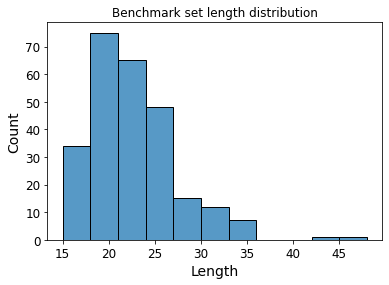

In [ ]:
# Seaborn histogram
ax = sns.histplot(data=lengths, binwidth=3)
ax.set(xlabel='Length', ylabel='Count', title='Benchmark set length distribution')
img = ax.get_figure()
plt.show()
img.savefig('BS_length_histplot.png')

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


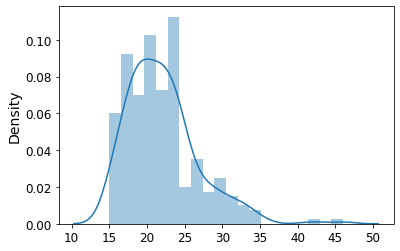

In [ ]:
# density plot
sns.distplot(lengths)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


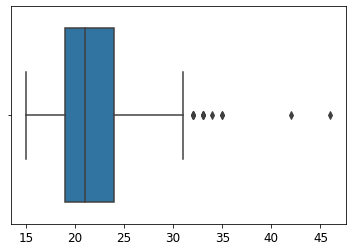

In [ ]:
# boxplot
sns.boxplot(lengths)

## Residues comparative distribution

{'M': 3.7054263565891534, 'R': 3.8294573643410916, 'F': 4.372093023255821, 'L': 13.930232558139558, 'A': 9.558139534883736, 'T': 5.465116279069776, 'S': 7.612403100775206, 'Q': 3.240310077519385, 'E': 4.000000000000006, 'P': 5.333333333333342, 'V': 7.56589147286823, 'K': 4.007751937984502, 'D': 3.3875968992248118, 'C': 3.8682170542635723, 'G': 7.255813953488384, 'I': 4.178294573643417, 'N': 3.0232558139534933, 'Y': 2.263565891472872, 'W': 1.5658914728682196, 'H': 1.6821705426356617}


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


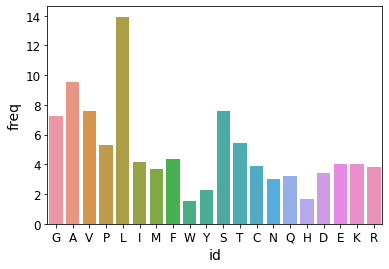

In [ ]:
# SP composition
num_seq = df_sp.shape[0]
sp_freq = {}
for n_term in df_sp["Sequence (first 50 N-terminal residues)"]:
  for aa in n_term:
    if aa in sp_freq:
      sp_freq[aa] += 100/(num_seq*50)
    else: 
      sp_freq[aa] = 0
      
print(sp_freq)

# Convert dict to df
sp_freq_df = pd.DataFrame.from_dict(sp_freq, orient='index')
sp_freq_df.columns = ['freq']
sp_freq_df.reset_index(level=0, inplace=True)

# Sort by polarity
sp_freq_df['index'] = pd.Categorical(sp_freq_df['index'], ["G","A","V","P","L","I","M","F","W","Y","S","T","C","N","Q","H","D","E","K","R"])
sp_freq_df.sort_values("index",inplace=True)
sp_freq_df.rename(columns={'index':'id'}, inplace=True)
sp_freq_df.tail()

# Plot
sns.barplot(sp_freq_df['id'], y=sp_freq_df['freq'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


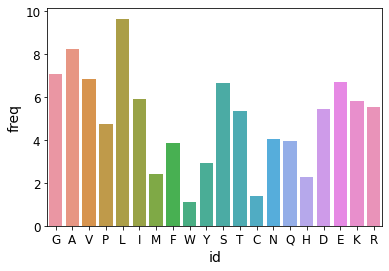

In [ ]:
# Background composition

bg_aa = pd.read_table("aa.txt", sep = " ",header = None)
bg_aa.columns = ["Res","id","freq"]
bg_aa['id'] = pd.Categorical(bg_aa['id'], ["G","A","V","P","L","I","M","F","W","Y","S","T","C","N","Q","H","D","E","K","R"])
bg_aa.sort_values("id",inplace=True)

# Converts bg freqs to floats
pd.to_numeric(bg_aa['freq'])

# Plot
sns.barplot(bg_aa['id'], y=bg_aa['freq'])

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


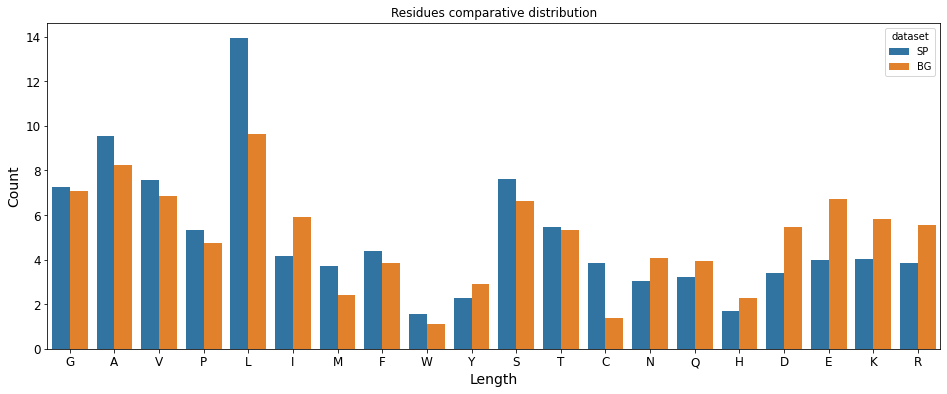

In [ ]:
# Compare compositions - SEABORN

plt.figure(figsize=(16,6))
merged = pd.merge(bg_aa, sp_freq_df, on='id')
merged.rename(columns={'freq_x':'BG', 'freq_y':'SP'}, inplace=True)
merged = merged[['id', 'SP', 'BG']]
merged = merged.melt(id_vars=['id'], var_name='dataset', value_name='frequencies')
merged.tail()

ax = sns.barplot(merged['id'], y=merged['frequencies'], hue=merged['dataset'])
ax.set(xlabel='Length', ylabel='Count', title='Residues comparative distribution')
plt.show()

# Save Image
# img = ax.get_figure()
# img.savefig('TS_comparative_dist.png')



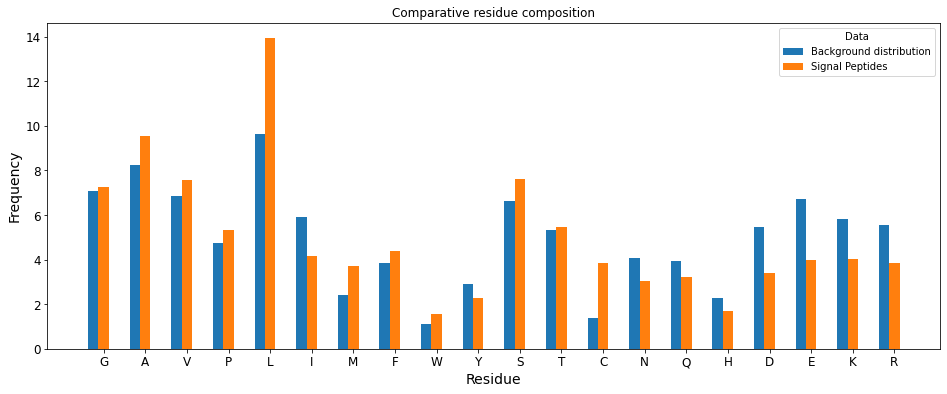

In [ ]:
# Compare compositions - MATPLOTLIB

plt.figure(figsize=(16, 6))
width = 0.25
plt.bar(np.arange(bg_aa.shape[0])-width, bg_aa["freq"], width, label="Background distribution")
plt.bar(np.arange(bg_aa.shape[0]), sp_freq_df["freq"], width, label="Signal Peptides")

plt.xticks(np.arange(bg_aa.shape[0]), bg_aa["id"])

plt.title("Comparative residue composition")
plt.legend(title="Data")
plt.xlabel('Residue')
plt.ylabel('Frequency')
plt.savefig('TS_comparative_dist.png')
plt.show()


## Taxonomy

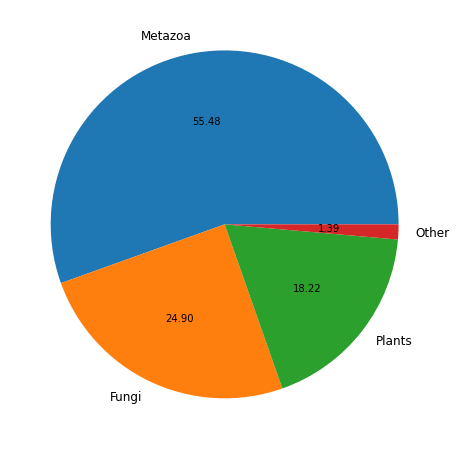

In [ ]:
# Kingdom
kingdoms = df['Kingdom'].value_counts()
plot = kingdoms.plot.pie(figsize=(8,8), autopct='%.2f')
plt.ylabel('')
plt.savefig('BS_taxonomy_kingdom.png')

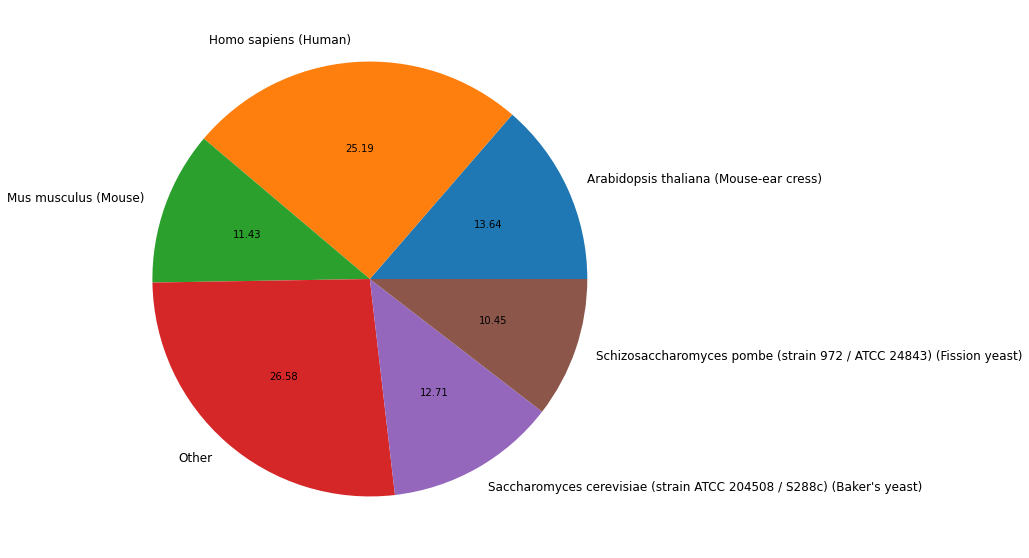

In [ ]:
# Taxa

# from df to series of counts
taxa = df['Taxa'].value_counts()
# from series to df 
taxa = taxa.to_frame(name='count')
# convert index into col  
taxa = taxa.reset_index()
# change to Other if <= 15
taxa['index'].mask(taxa['count'] <= 70, 'Other', inplace=True)
# Aggregate entries labelled as Other
taxa = taxa.groupby(taxa['index']).aggregate({'count': 'sum'})


# Plot
plot = taxa.plot.pie(y='count', figsize=(10,10), legend=False, autopct='%.2f')
plt.ylabel('')
plt.savefig('BS_taxonomy_taxa.png')

## Sequence logo

In [ ]:
df_logo = df_sp[['Sequence (first 50 N-terminal residues)','SP cleavage-site annotation']]
df_logo.tail()

,Sequence (first 50 N-terminal residues),SP cleavage-site annotation
1425,MIMLLMVGMLMAPCVGAHALDTPNPQELPPGLSKNINITFFNGVFK...,SSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1426,MMKFTVVAAALLLLGAVRAEEEDKKEDVGTVVGIDLGTTYSCVGVF...,SSSSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1427,MRSAAVLALLLCAGQVTALPVNSPMNKGDTEVMKCIVEVISDTLSK...,SSSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1428,MSSGGLLLLLGLLTLWAELTPVSGKKRPDFCYLPADTGPCMANFPR...,SSSSSSSSSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNN...
1429,MLLQGALLLLLALPSHGEDNMEDPPLPKGACAGWMAGIPGHPGHNG...,SSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...


In [ ]:
# Select (-13,+2) as region to depict, wrt annotation
motifs = []
for index in df_logo['SP cleavage-site annotation'].index.values:

  seq = df_logo['Sequence (first 50 N-terminal residues)'][index]
  annot = df_logo['SP cleavage-site annotation'][index]
  cl_site = annot.find('N')
  start = cl_site - 13
  motifs.append(seq[start:cl_site+2])


file = open('motifs.txt', 'w')

for m in motifs:
    file.write(m)
    file.write('\n')

file.close()

# SVM

## Training

In [ ]:
# Check dataframe
df.tail()

,UniProtKB accession,Taxa,Kingdom,Class,Cross-validation fold,Sequence (first 50 N-terminal residues),SP cleavage-site annotation,Real Class
1718,P62597,Gallus gallus (Chicken),Metazoa,NO_SP,4,MPVQVLKIIKGKPETQLPSHLQREDLKHLQTGLDHTNKYFQGIVIL...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.0
1719,Q7K4M4,Drosophila melanogaster (Fruit fly),Metazoa,NO_SP,4,MSKFLDMLSGSQCVSLEKCGDVVVSTNDCMIALYCHFCRDLFTQLP...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.0
1720,Q14146,Homo sapiens (Human),Metazoa,NO_SP,4,MAAVYSGISLKLKSKTTSWEDKLKLAHFAWISHQCFLPNKEQVLLD...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.0
1721,B2RWS6,Mus musculus (Mouse),Metazoa,NO_SP,4,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.0
1722,Q9P6R0,Schizosaccharomyces pombe (strain 972 / ATCC 2...,Fungi,NO_SP,4,MGCPNCGSTTFESDTASGNTYCTQCGVVVEQDAIVSEVTFGEASTG...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.0


### Train and optimize the SVM with GridSearchCV

#### Predefined split and gridsearchcv

In [ ]:
# Initialize empty matrix with lenght 20xN(sequences)
res_order = ["G","A","V","P","L","I","M","F","W","Y","S","T","C","N","Q","H","D","E","K","R"]

# Encode residue frequency for each sequence
seq_list = df['Sequence (first 50 N-terminal residues)'].tolist()
X_list = []
K = [19, 20, 21, 22, 23, 24]

for k in K:
  X = np.zeros((len(seq_list),20))
  for i in range(len(seq_list)):
    ks = seq_list[i][:k]
    for j in range(k):
      res = ks[j]
      X[i][res_order.index(res)] += 1/k
  X_list.append(X)

# Extract real classification vector
y = df['Real Class'].astype(int).tolist()

In [ ]:
# PredefinedSplit

# Indices for Predefined split
cv_indices = []
for i in range(len(df)):
    cv_indices.append(df['Cross-validation fold'][i])

# Create predefined split object
ps = PredefinedSplit(cv_indices)

# Check splits
for train_index, test_index in ps.split():
  print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 345  346  347 ... 1720 1721 1722] TEST: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 2

#### Custom scoring f with matthew corr

In [ ]:
def mcc(y_true, y_pred):

  TP, FP, FN, TN = 0, 0, 0, 0

  # Confusion matric
  for true, pred in zip(y_true, y_pred):

      if true == 0 and pred == 0:
        TP += 1
      if true == 1 and pred == 1:
        TN += 1
      if true == 0 and pred == 1:
        FP += 1
      elif true == 1 and pred == 0:
        FN += 1

  # MCC
  num = TP*TN - FP*FN
  den = np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
  mcc = num/den

  return mcc


# Custom scorer
custom_scoring = make_scorer(mcc, greater_is_better=True)

#### Grid search



Notice that C = 1.0 and gamma = 0.1 raised error due to double scalar calculations.

##### MCC

In [ ]:
# Initialize a performance summary dataframe

cv_SVM_summary = pd.DataFrame(columns=['MCC', 'Q2', 'Precision', 'Recall', 'F1'], index=['SVM'])

In [ ]:
K = [19, 20, 21, 22, 23, 24]

best = 0
std = 0

for k in range(len(K)):  

  tuned_parameters = {"C": [i for i in range(1,20)], 
                      "gamma": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 'scale']}

  clf =  GridSearchCV(SVC(kernel='rbf'),
          tuned_parameters, scoring=custom_scoring, cv=ps)
  clf.fit(X_list[k], y)

  print("Best parameters set found on training set with k = %s: " % K[k])
  print()
  print(clf.best_params_)
  print()
  print(clf.cv_results_["mean_test_score"].max())
  print()

  if clf.cv_results_["mean_test_score"].max() > best:
    index = clf.cv_results_["mean_test_score"].argmax()
    best = clf.cv_results_["mean_test_score"].max()
    std = clf.cv_results_["std_test_score"][index] # Find standard dev

mean = best
std = std
cv_SVM_summary['MCC'] = "{mean:.4f} +/- {se:.4f}".format(mean=mean, se=std/(5**(.5)))

Best parameters set found on training set with k = 19: 

{'C': 16, 'gamma': 0.8}

0.8578173223013147

Best parameters set found on training set with k = 20: 

{'C': 13, 'gamma': 0.9}

0.8441273309583208

Best parameters set found on training set with k = 21: 

{'C': 12, 'gamma': 0.8}

0.8185430290999058

Best parameters set found on training set with k = 22: 

{'C': 12, 'gamma': 1}

0.8154366070853494

Best parameters set found on training set with k = 23: 

{'C': 3, 'gamma': 'scale'}

0.7942412235249341

Best parameters set found on training set with k = 24: 

{'C': 17, 'gamma': 0.8}

0.7861645438630388



In [ ]:
cv_SVM_summary

,MCC,Q2,Precision,Recall,F1
SVM,0.8578 +/- 0.0131,NaN,NaN,NaN,NaN


##### Accuracy, Precision, recall, F1

In [ ]:
tuned_parameters = {"C": [16], 
                    "gamma": [.8]}
scores = ["accuracy", "precision", "recall", "f1"]
formatted_scores = ['Q2', 'Precision', 'Recall', 'F1']

for score in scores:
  print("# Tuning hyper-parameters for %s" % score)
  print()

  clf =  GridSearchCV(SVC(kernel='rbf'),
          tuned_parameters, scoring="%s" % score, cv=ps)
  clf.fit(X_list[0], y)

  print("Best parameters set found on development set:")
  print()
  print(clf.best_params_)
  print()
  print(clf.cv_results_["mean_test_score"][0])
  print()
  print()

  mean = clf.cv_results_["mean_test_score"][0]
  std = clf.cv_results_["std_test_score"][0]
  cv_SVM_summary[formatted_scores[scores.index(score)]] = "{mean:.4f} +/- {se:.4f}".format(mean=mean, se=std/(5**(.5)))
  

# Tuning hyper-parameters for accuracy

Best parameters set found on development set:

{'C': 16, 'gamma': 0.8}

0.9640174082055182


# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 16, 'gamma': 0.8}

0.9065091185410333


# Tuning hyper-parameters for recall

Best parameters set found on development set:

{'C': 16, 'gamma': 0.8}

0.852923076923077


# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 16, 'gamma': 0.8}

0.8771199716462874




In [ ]:
cv_SVM_summary

,MCC,Q2,Precision,Recall,F1
SVM,0.8578 +/- 0.0131,0.9640 +/- 0.0035,0.9065 +/- 0.0267,0.8529 +/- 0.0136,0.8771 +/- 0.0105


In [ ]:
# Crossvalidation summary

mcc_results = pd.DataFrame.from_dict(clf.cv_results_)
mcc_results = mcc_results[['params', 'mean_test_score', 'std_test_score']]

mcc_results['se_test'] = mcc_results.std_test_score/(5**(.5))

In [ ]:
mcc_results

,params,mean_test_score,std_test_score,se_test
0,"{'C': 16, 'gamma': 0.8}",0.87712,0.023589,0.010549


## Benchmarking

### Select dataset for benchmarking

In [ ]:
bm_df = pd.read_table('benchmark_set.tsv')
bm_df.head()

,UniProtKB accession,Taxa,Kingdom,Class,Sequence (first 50 N-terminal residues),SP cleavage-site annotation
0,Q8TF40,Homo sapiens (Human),Metazoa,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1,Q1ENB6,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
2,Q9BZS1,Homo sapiens (Human),Metazoa,NO_SP,MPNPRPGKPSAPSLALGPSPGASPSWRAAPKASDLLGARGPGGTFQ...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
3,F4K2A1,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MFAVSIVPRTTSCRLSSAFLCQLSIPLTLRLHHHYQHHQPHLPSPL...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
4,Q9SZL8,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MMDNEVLDFDIGVGVSSGGDVDDDAIDIEHHALDDDDMLDSPIMPC...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...


In [ ]:
# Binarize classes
bm_df.loc[bm_df['Class'] == 'SP', 'Real Class'] = 1
bm_df.loc[bm_df['Class'] == 'NO_SP', 'Real Class'] = 0

### Features encoding and real class vectors

In [ ]:
# Encode residue frequency for each sequence
res_order = ["G","A","V","P","L","I","M","F","W","Y","S","T","C","N","Q","H","D","E","K","R"]
seq_list = bm_df['Sequence (first 50 N-terminal residues)'].tolist()

X = np.zeros((len(seq_list),20))
for i in range(len(seq_list)):
  ks = seq_list[i][:19]
  for j in range(19):
    res = ks[j]
    X[i][res_order.index(res)] += 1/19


# Extract real classification vector
y = bm_df['Real Class'].astype(int).tolist()

## Performance metrics summary

In [ ]:
def perf_metrics(TP, FP, FN, TN):
  '''
  from real classes and predicted classes, function estimates matthew correlation
  coefficient, accuracy, precision, recall and F1 score.
  '''
  
  # MCC
  num = TP*TN - FP*FN
  den = np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))
  mcc = num/den

  # Accuracy
  acc = (TP+TN)/(TP+TN+FP+FN)

  # Precision
  pres = TP/(TP+FP)

  # Recall
  recall = TP/(TP+FN)

  # F1 score
  F1 = (2*pres*recall)/(pres+recall)

  # False Positives Rate
  fpr = FP/(FP+TN)

  return mcc,acc,pres,recall,F1,fpr

In [ ]:
clf = SVC(C = 16, gamma = 0.8, kernel='rbf')

clf.fit(X, y)

y_true, y_pred = y, clf.predict(X)
TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

mcc,acc,pres,recall,F1, FPR = perf_metrics(TP, FP, FN, TN)
bm_SVM_summary = pd.DataFrame(data=[[mcc,acc,pres,recall, FPR, F1]], 
                              columns=('MCC', 'Q2', 'Precision', 'Recall', 'FPR', 'F1'),
                               index=['SVM'])

# Results
bm_SVM_summary[['MCC', 'Q2', 'Precision', 'Recall', 'FPR', 'F1']]

bm_SVM_summary

,MCC,Q2,Precision,Recall,FPR,F1
SVM,0.612169,0.982162,0.811475,0.473684,0.003174,0.598187


## False results

In [ ]:
# Extract false results

results = []

for i in range(len(y_pred)):
  if bm_df['Real Class'][i] == 1.0 and y_pred[i] == 0:
    results.append('FN')
  elif bm_df['Real Class'][i] == 0.0 and y_pred[i] == 1:
    results.append('FP')
  else:
    results.append('True')

bm_df['Results'] = results

### False positives

In [ ]:
# Extract accession codes
svm_fpos_df = bm_df[bm_df['Results'] == 'FP'][['UniProtKB accession', 'Kingdom', 'Sequence (first 50 N-terminal residues)', 'SP cleavage-site annotation']]
svm_fpos = svm_fpos_df['UniProtKB accession'].values

In [ ]:
len(svm_fpos)

23

### False negatives

In [ ]:
# Extract false negatives
svm_fneg_df = bm_df[bm_df['Results'] == 'FN'][['UniProtKB accession', 'Kingdom', 'Sequence (first 50 N-terminal residues)', 'SP cleavage-site annotation']]

In [ ]:
len(svm_fneg_df)

110

# Von Heijne Method

## Training

In [ ]:
# Extraction of (-13; +2) segment around cleavage site

sp = []

for i in range(len(df['SP cleavage-site annotation'])):
  
  seq = df['Sequence (first 50 N-terminal residues)'][i]
  annot = df['SP cleavage-site annotation'][i]
  cl_site = annot.find('N')
  start = cl_site - 13
  if start < 0:
    sp.append(seq[0:15])
  else: 
    sp.append(seq[start:cl_site+2])

# Add motifs to dataframe
df['Signal Peptide'] = sp
df

,UniProtKB accession,Taxa,Kingdom,Class,Cross-validation fold,Sequence (first 50 N-terminal residues),SP cleavage-site annotation,Real Class,Signal Peptide
0,P61916,Homo sapiens (Human),Metazoa,SP,0,MRFLAATFLLLALSTAAQAEPVQFKDCGSVDGVIKEVNVSPCPTQP...,SSSSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1.0,TFLLLALSTAAQAEP
1,Q7M3V1,Chelonus sp. nr. curvimaculatus (Parasitic wasp),Metazoa,SP,0,MAGKEVIFIMALFIAVESSPIFSFDDLVCPSVTSLRVNVEKNECST...,SSSSSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNN...,1.0,FIMALFIAVESSPIF
2,Q08738,Bombyx mori (Silk moth),Metazoa,SP,0,MRVFLAICLSLTVALAAETGKYTPFQYNRVYSTVSPFVYKPGRYVA...,SSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1.0,FLAICLSLTVALAAE
3,Q41350,Solanum lycopersicum (Tomato) (Lycopersicon es...,Plants,SP,0,MASSSAKILLPLSLLFTLLSLSQSTNPNFILTLVNNCPYTIWPAIQ...,SSSSSSSSSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNN...,1.0,LSLLFTLLSLSQSTN
4,Q86SE1,Androctonus amoreuxi (African fattail scorpion...,Metazoa,SP,0,MNYLVMISLALLLMIGVESVRDGYIVYPHNCVYHCIPSCDGLCKEN...,SSSSSSSSSSSSSSSSSSSNNNNNNNNNNNNNNNNNNNNNNNNNNN...,1.0,ISLALLLMIGVESVR
...,...,...,...,...,...,...,...,...,...
1718,P62597,Gallus gallus (Chicken),Metazoa,NO_SP,4,MPVQVLKIIKGKPETQLPSHLQREDLKHLQTGLDHTNKYFQGIVIL...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.0,MPVQVLKIIKGKPET
1719,Q7K4M4,Drosophila melanogaster (Fruit fly),Metazoa,NO_SP,4,MSKFLDMLSGSQCVSLEKCGDVVVSTNDCMIALYCHFCRDLFTQLP...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.0,MSKFLDMLSGSQCVS
1720,Q14146,Homo sapiens (Human),Metazoa,NO_SP,4,MAAVYSGISLKLKSKTTSWEDKLKLAHFAWISHQCFLPNKEQVLLD...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.0,MAAVYSGISLKLKSK
1721,B2RWS6,Mus musculus (Mouse),Metazoa,NO_SP,4,MAENVVEPGPPSAKRPKLSSPALSASASDGTDFGSLFDLEHDLPDE...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,0.0,MAENVVEPGPPSAKR


In [ ]:
# Process background frequencies to weight the pswm
bg_aa = pd.read_table("aa.txt", sep = " ",header = None)
bg_aa.columns = ["Res","id","freq"]
bg_aa['id'] = pd.Categorical(bg_aa['id'], ["G","A","V","P","L","I","M","F","W","Y","S","T","C","N","Q","H","D","E","K","R"])
bg_aa.sort_values("id",inplace=True)
bg_aa['freq'] = bg_aa['freq']/100


### Helper functions

In [ ]:
# One hot encoding
def one_hot_encode(seq):

  code = ["G","A","V","P","L","I","M","F","W","Y","S","T","C","N","Q","H","D","E","K","R"]

  # res that are not in seq
  o = list(set(code) - set(seq))
  x = pd.DataFrame(np.zeros((len(seq),len(o)), dtype=int), columns=o) 
  # save 1 for each res in seq
  s = pd.DataFrame(list(seq))
  matrix = s[0].str.get_dummies(sep=',')
  # join counted res and nonpresent res
  matrix = matrix.join(x)
  # gives desired order
  matrix = matrix[code]
  # extract count of sequence res
  count = matrix.values 

  return count


# Compute position-specific weight matrix
def compute_pswm(motifs_df, background_freqs):

  # Initialize matrix with ones
  freq_matrix = np.ones((15,20))

  # Position specific probability (frequency) matrix
  for seq in motifs_df:
    freq_matrix = freq_matrix + one_hot_encode(seq)
  freq_matrix = freq_matrix/ (20+len(motifs_df))

  # Weight the frequency matrix with background frequencies
  for freq,j in zip(bg_aa['freq'], range(0,20)):
    for i in range(0,15):
      freq_matrix[i][j] = freq_matrix[i][j] / freq

  # Compute log to obtain the Position-Specific Weight Matrix
  PSWM = np.log2(freq_matrix)

  return PSWM


# Define a scoring function
def scoring(pswm, sequence_set, res_order = "GAVPLIMFWYSTCNQHDEKR"):

  scores = []

  for seq in sequence_set:
    best_s = -999
    # sliding windows
    a=0
    while a <= 35:
      seq1 = seq[a:a+15]
      # sum over the window
      s = 0
      for i,res in enumerate(seq1):
        col_index = res_order.find(res)
        s += pswm[i, col_index]
      # save best window score
      if s > best_s:
        best_s = s
      # slide the window
      a += 1
    
    # save sequence best score  
    scores.append(best_s)

  return scores

In [ ]:
def cv_run(df, fold, background_freqs):

  '''
  Compute pswm on leave-one-out, score the leave-one-out, test on the one-left-out.
  Compute optimal threshold and based on that, compute the number of true and false results
  returns the threshold, and the related confusion matrix.
  '''

  # Select training set on basis of the fold
  df_train = df[df['Cross-validation fold'] != fold]
  df_train_sp = df_train[df_train['Class'] == 'SP']
  train_sp_set = df_train_sp['Signal Peptide']
  train_seqs_set = df_train['Sequence (first 50 N-terminal residues)']

  # Train pswm on training set
  PSWM = compute_pswm(train_sp_set, background_freqs)

  # Score and evaluate best threshold
  y_train_scores = scoring(PSWM, train_seqs_set)
  y_train = df_train['Real Class'].tolist()
  precision, recall, thresholds = precision_recall_curve(y_train, y_train_scores)
  fscore = (2 * precision * recall) / (precision + recall)
  index = np.argmax(fscore)
  opt_thr = thresholds[index]

  # Select testing set
  df_test = df[df['Cross-validation fold'] == fold]
  test_seqs_set = df_test['Sequence (first 50 N-terminal residues)']

  # test the threshold on the left-out set
  y_test_scores = scoring(PSWM, test_seqs_set)
  y_pred = [int(t_s >= opt_thr) for t_s in y_test_scores]
  y_true = df_test['Real Class']

  # compute confusion matrix
  TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

  return opt_thr, TP, FP, FN, TN

### Display confusion matrix of a given cv subset

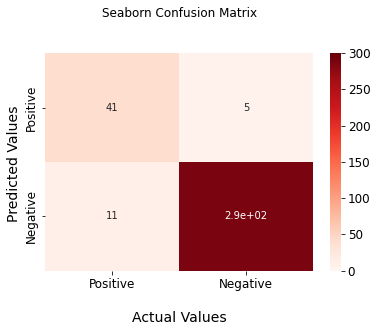

In [ ]:
# Display Confusion Matrix of a given subset
fold = 0
opt_thr, TP, FP, FN, TN = cv_run(df, fold, bg_aa)
cm = np.array([[TP, FP],[FN, TN]])

ax = sns.heatmap(cm, annot=True, cmap="Reds", vmin=0, vmax=300)

ax.set_title('Seaborn Confusion Matrix\n\n');
ax.set_xlabel('\nActual Values')
ax.set_ylabel('Predicted Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Positive','Negative'])
ax.yaxis.set_ticklabels(['Positive','Negative',])

## Display the visualization of the Confusion Matrix.
plt.show()

### CV runs and metrics

In [ ]:
# Perform runs of cross validation and evaluate metrics

runs = pd.DataFrame(columns=('opt_thr', 'TP', 'FP', 'FN', 'TN', 'MCC', 
                               'Accuracy', 'Precision', 'Recall', 'FPR', 'F1'), index=(range(5)))

for i in range(5):

  thr, TP, FP, FN, TN = cv_run(df, i, bg_aa)
  mcc,acc,pres,recall,F1, FPR = perf_metrics(TP, FP, FN, TN)

  runs.iloc[i] = thr, TP, FP, FN, TN, mcc, acc, pres, recall, FPR, F1

#runs.transpose()
runs

# Save cv_summary as image
dfi.export(runs,"VH_CV_summary.png")

In [ ]:
# Compute average threshold for benchmarking

avg_thr = runs['opt_thr'].mean()
avg_thr

8.205864702875445

In [ ]:
# CROSS VALIDATION SUMMARY

cv_VH_summary = pd.DataFrame(columns=['MCC', 'Q2', 'Precision', 'Recall', 'F1'], index=['Von Heijne'])


# Compute standard error
mcc_se = runs['MCC'].std()/(5**(.5))
Q2_se = runs['Accuracy'].std()/(5**(.5))
Pre_se = runs['Precision'].std()/(5**(.5))
Rec_se = runs['Recall'].std()/(5**(.5))
F1_se = runs['F1'].std()/(5**(.5))

mcc = "{mean:.4f} +/- {se:.4f}".format(mean=runs['MCC'].mean(), se=mcc_se)
Q2 = "{mean:.4f} +/- {se:.4f}".format(mean=runs['Accuracy'].mean(), se=Q2_se)
Pre = "{mean:.4f} +/- {se:.4f}".format(mean=runs['Precision'].mean(), se=Pre_se)
Rec = "{mean:.4f} +/- {se:.4f}".format(mean=runs['Recall'].mean(), se=Rec_se)
F1 = "{mean:.4f} +/- {se:.4f}".format(mean=runs['F1'].mean(), se=F1_se)

cv_VH_summary.loc['Von Heijne'] = mcc, Q2, Pre, Rec, F1


In [ ]:
cv_VH_summary

,MCC,Q2,Precision,Recall,F1
Von Heijne,0.7839 +/- 0.0114,0.9454 +/- 0.0039,0.8432 +/- 0.0315,0.7908 +/- 0.0163,0.8135 +/- 0.0086


## Benchmarking

In [ ]:
benchmarking_dataset = str(input('dataset: '))
bm_df = pd.read_table(benchmarking_dataset)
bm_df

dataset: benchmark_set.tsv


,UniProtKB accession,Taxa,Kingdom,Class,Sequence (first 50 N-terminal residues),SP cleavage-site annotation
0,Q8TF40,Homo sapiens (Human),Metazoa,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
1,Q1ENB6,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
2,Q9BZS1,Homo sapiens (Human),Metazoa,NO_SP,MPNPRPGKPSAPSLALGPSPGASPSWRAAPKASDLLGARGPGGTFQ...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
3,F4K2A1,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MFAVSIVPRTTSCRLSSAFLCQLSIPLTLRLHHHYQHHQPHLPSPL...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
4,Q9SZL8,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MMDNEVLDFDIGVGVSSGGDVDDDAIDIEHHALDDDDMLDSPIMPC...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
...,...,...,...,...,...,...
7451,O74327,Homo sapiens (Human),Metazoa,NO_SP,MSGYSPLSSGPADVHIGKAGFFSSVINLANTILGAGILSLPNAFTK...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
7452,Q9UM00,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MSTMFADTLLIVFISVCTALLAEGITWVLVYRTDKYKRLKAEVEKQ...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
7453,Q93Y07,Homo sapiens (Human),Metazoa,NO_SP,MELFALLIKVAGLLATVTVGANVVSYSRFRRQNLAKFRSPIDESKE...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...
7454,Q86TL2,Mus musculus (Mouse),Metazoa,NO_SP,MQGPAGNASRGLPGGPPSTVASGAGRCESGALMHSFGIFLQGLLGV...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...


In [ ]:
# Extraction of (-13; +2) segment around cleavage site
sp = []

for i in range(len(bm_df['SP cleavage-site annotation'])):
  
  seq = bm_df['Sequence (first 50 N-terminal residues)'][i]
  annot = bm_df['SP cleavage-site annotation'][i]
  cl_site = annot.find('N')
  start = cl_site - 13
  if start < 0:
    sp.append(seq[0:15])
  else: 
    sp.append(seq[start:cl_site+2])

# Add motifs to dataframe
bm_df['Signal Peptide'] = sp

# Binarize classes to estimate performance metrics
bm_df.loc[bm_df['Class'] == 'SP', 'Real Class'] = 1
bm_df.loc[bm_df['Class'] == 'NO_SP', 'Real Class'] = 0


bm_df

,UniProtKB accession,Taxa,Kingdom,Class,Sequence (first 50 N-terminal residues),SP cleavage-site annotation,Signal Peptide,Real Class
0,Q8TF40,Homo sapiens (Human),Metazoa,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MAPTLFQKLFSKRTG,0.0
1,Q1ENB6,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MDFTSLETTTFEEVV,0.0
2,Q9BZS1,Homo sapiens (Human),Metazoa,NO_SP,MPNPRPGKPSAPSLALGPSPGASPSWRAAPKASDLLGARGPGGTFQ...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MPNPRPGKPSAPSLA,0.0
3,F4K2A1,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MFAVSIVPRTTSCRLSSAFLCQLSIPLTLRLHHHYQHHQPHLPSPL...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MFAVSIVPRTTSCRL,0.0
4,Q9SZL8,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MMDNEVLDFDIGVGVSSGGDVDDDAIDIEHHALDDDDMLDSPIMPC...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MMDNEVLDFDIGVGV,0.0
...,...,...,...,...,...,...,...,...
7451,O74327,Homo sapiens (Human),Metazoa,NO_SP,MSGYSPLSSGPADVHIGKAGFFSSVINLANTILGAGILSLPNAFTK...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MSGYSPLSSGPADVH,0.0
7452,Q9UM00,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MSTMFADTLLIVFISVCTALLAEGITWVLVYRTDKYKRLKAEVEKQ...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MSTMFADTLLIVFIS,0.0
7453,Q93Y07,Homo sapiens (Human),Metazoa,NO_SP,MELFALLIKVAGLLATVTVGANVVSYSRFRRQNLAKFRSPIDESKE...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MELFALLIKVAGLLA,0.0
7454,Q86TL2,Mus musculus (Mouse),Metazoa,NO_SP,MQGPAGNASRGLPGGPPSTVASGAGRCESGALMHSFGIFLQGLLGV...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MQGPAGNASRGLPGG,0.0


In [ ]:
# Produce pswm on positive training set
df_sp = df[df.Class == 'SP']
motifs = df_sp['Signal Peptide']
pswm = compute_pswm(motifs, bg_aa)

# Score each sequence
bm_seqs = bm_df['Sequence (first 50 N-terminal residues)']
y_bm_scores = scoring(pswm, bm_seqs)

# Filter according to avg_thr
y_bm_pred = [int(t_s >= avg_thr) for t_s in y_bm_scores]
bm_df['Predicted Class'] = y_bm_pred
y_bm_true = bm_df['Real Class']

# Compute performance metrics
TN, FP, FN, TP = confusion_matrix(y_bm_true, y_bm_pred).ravel()

mcc,acc,pres,recall,F1, FPR = perf_metrics(TP, FP, FN, TN)
bm_VH_summary = pd.DataFrame(data=[[TP, FP, FN, TN, mcc,acc,pres,recall,FPR,F1]], 
                              columns=('TP', 'FP', 'FN', 'TN', 
                                     'MCC', 'Q2', 'Precision', 'Recall', 'FPR', 'F1'),
                               index=['Von Heijne'])

# Results
bm_VH_summary = bm_VH_summary[['MCC', 'Q2', 'Precision', 'Recall', 'FPR', 'F1']]
bm_VH_summary

,MCC,Q2,Precision,Recall,FPR,F1
Von Heijne,0.581546,0.970091,0.478395,0.741627,0.02332,0.581614


## False results

In [ ]:
bm_df.head()

,UniProtKB accession,Taxa,Kingdom,Class,Sequence (first 50 N-terminal residues),SP cleavage-site annotation,Signal Peptide,Real Class,Predicted Class
0,Q8TF40,Homo sapiens (Human),Metazoa,NO_SP,MAPTLFQKLFSKRTGLGAPGRDARDPDCGFSWPLPEFDPSQIRLIV...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MAPTLFQKLFSKRTG,0.0,0
1,Q1ENB6,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MDFTSLETTTFEEVVIALGSNVGNRMNNFKEALRLMKDYGISVTRH...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MDFTSLETTTFEEVV,0.0,0
2,Q9BZS1,Homo sapiens (Human),Metazoa,NO_SP,MPNPRPGKPSAPSLALGPSPGASPSWRAAPKASDLLGARGPGGTFQ...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MPNPRPGKPSAPSLA,0.0,0
3,F4K2A1,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MFAVSIVPRTTSCRLSSAFLCQLSIPLTLRLHHHYQHHQPHLPSPL...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MFAVSIVPRTTSCRL,0.0,0
4,Q9SZL8,Arabidopsis thaliana (Mouse-ear cress),Plants,NO_SP,MMDNEVLDFDIGVGVSSGGDVDDDAIDIEHHALDDDDMLDSPIMPC...,NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN...,MMDNEVLDFDIGVGV,0.0,0


In [ ]:
# Extract false results

results = []

for i in range(len(y_pred)):
  if bm_df['Real Class'][i] == 1.0 and bm_df['Predicted Class'][i] == 0:
    results.append('FN')
  elif bm_df['Real Class'][i] == 0.0 and bm_df['Predicted Class'][i] == 1:
    results.append('FP')
  else:
    results.append('True')

bm_df['Results'] = results

### False positives

In [ ]:
# Extract accession codes
vh_fpos_df = bm_df[bm_df['Results'] == 'FP'][['UniProtKB accession', 'Kingdom', 'Sequence (first 50 N-terminal residues)', 'SP cleavage-site annotation']]
vh_fpos = vh_fpos_df['UniProtKB accession'].values

In [ ]:
len(vh_fpos)

169

### False negatives

In [ ]:
# Extract false negatives
vh_fneg_df = bm_df[bm_df['Results'] == 'FN'][['UniProtKB accession', 'Kingdom', 'Sequence (first 50 N-terminal residues)', 'SP cleavage-site annotation']]

In [ ]:
len(vh_fneg_df)

54

# Methods performance summary and comparison

## Cross-validation

In [ ]:
# Merge summary from Von Heijne and from SVM
cv_summary = pd.concat([cv_VH_summary, cv_SVM_summary], axis=0)
cv_summary.transpose()

,Von Heijne,SVM
MCC,0.7839 +/- 0.0114,0.8578 +/- 0.0131
Q2,0.9454 +/- 0.0039,0.9640 +/- 0.0035
Precision,0.8432 +/- 0.0315,0.9065 +/- 0.0267
Recall,0.7908 +/- 0.0163,0.8529 +/- 0.0136
F1,0.8135 +/- 0.0086,0.8771 +/- 0.0105


In [ ]:
cv_summary_styled = cv_summary

cv_summary_styled = cv_summary_styled.style.set_caption('Cross-validation Performance Metrics')
cv_summary_styled = cv_summary_styled.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])
cv_summary_styled = cv_summary_styled.background_gradient() #adding a gradient based on values in cell
cv_summary_styled

,MCC,Q2,Precision,Recall,F1
Von Heijne,0.7839 +/- 0.0114,0.9454 +/- 0.0039,0.8432 +/- 0.0315,0.7908 +/- 0.0163,0.8135 +/- 0.0086
SVM,0.8578 +/- 0.0131,0.9640 +/- 0.0035,0.9065 +/- 0.0267,0.8529 +/- 0.0136,0.8771 +/- 0.0105


In [ ]:
# Save cv_summary as image
dfi.export(cv_summary.transpose(),"cv_summary.png")

## Benchmarking

In [ ]:
# Merge summary from Von Heijne and from SVM
bm_summary = pd.concat([bm_VH_summary, bm_SVM_summary], axis=0)
bm_summary.transpose()

,MCC,Q2,Precision,Recall,FPR,F1
Von Heijne,0.581546,0.970091,0.478395,0.741627,0.023320,0.581614
SVM,0.612169,0.982162,0.811475,0.473684,0.003174,0.598187


In [ ]:
bm_summary_styled = bm_summary

bm_summary_styled = bm_summary_styled.style.set_caption('Benchmarking Performance Metrics')
bm_summary_styled = bm_summary_styled.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])

bm_summary_styled

,MCC,Q2,Precision,Recall,FPR,F1
Von Heijne,0.581546,0.970091,0.478395,0.741627,0.023320,0.581614
SVM,0.612169,0.982162,0.811475,0.473684,0.003174,0.598187


In [ ]:
# Save cv_summary as image
dfi.export(bm_summary.transpose(),"bm_summary.png")

# False results

## False positives

**Transmembrane proteins**

The reason of false positives may be that SP has a transmembrane helix (high hydrophobicity) in the first 50-res.

To check that:
From Uniprot, retrieve and parse file of TM proteins having a TM in first 50-res (#TM).
Compute FP(TM)/#TM and compare with background FPR.




**Transit peptides**

Another possible reason of false prediction may be that some seqs are *transit peptides*, less strong hydrophobic core (alternated composition), but still predictable as signal peptides. As such we need to check TP for mitochondria, chloroplasts, peroxisomes.

To check that: From Uniprot, retrieve and parse file of TP proteins having a TP in first 50-res (#TM). 
- Compute FP(TPtotal)/#TP 
- Compute FP(TPmito)/#TP 
- Compute FP(TPchloro)/#TP 
- Compute FP(TPperox)/#TP

and compare with background FPR.

In [ ]:
bm = pd.read_table("benchmark_set.tsv")

negatives = bm[bm["Class"] == "NO_SP"]
negatives = negatives["UniProtKB accession"]

negatives = negatives.values

In [ ]:
results = json_parser(negatives)

results_FP_VH = json_parser(vh_fpos)

results_FP_SVM = json_parser(svm_fpos)

print('Negatives: ', results)
print('False positives VH: ', results_FP_VH)
print('False positives SVM: ', results_FP_SVM)

Fetched: 500 / 7248
Fetched: 1000 / 7248
Fetched: 1500 / 7248
Fetched: 2000 / 7248
Fetched: 2500 / 7248
Fetched: 3000 / 7248
Fetched: 3500 / 7248
Fetched: 4000 / 7248
Fetched: 4500 / 7248
Fetched: 5000 / 7248
Fetched: 5500 / 7248
Fetched: 6000 / 7248
Fetched: 6500 / 7248
Fetched: 7000 / 7248
Fetched: 7248 / 7248
Retrying in 3s
Fetched: 169 / 169
Fetched: 23 / 23
Negatives:  [148, 1393, 756, 624, 5]
False positives VH:  [44, 49, 25, 25, 0]
False positives SVM:  [17, 1, 1, 0, 0]


#### Rates computation

In [ ]:
results = np.array(results)
results_FP_VH = np.array(results_FP_VH)
results_FP_SVM = np.array(results_FP_SVM)

In [ ]:
# labels:
# vh = VonHejne   ; svm = Support Vector Machine
# tm = Transmembrane ;   tp = transit peptides ; tpm = transit mithocondrion ; tpc = transit Chloroplast ; tpp = transit peroxisome

tm_vh,tp_vh,tpm_vh,tpc_vh,tpp_vh = results_FP_VH/ results
tm_svm,tp_svm,tpm_svm,tpc_svm,tpp_svm = results_FP_SVM/ results

In [ ]:
# FP/(FP+TN)
TN = len(negatives)
FP_VH = len(vh_fpos)
FP_SVM = len(svm_fpos)
FPR_VH = FP_VH/TN
FPR_SVM = FP_SVM/TN

In [ ]:
print(FPR_VH,tm_vh,tp_vh,tpm_vh,tpc_vh,tpp_vh) 

0.023319994480474678 0.2972972972972973 0.035175879396984924 0.03306878306878307 0.04006410256410257 0.0


In [ ]:
print(FPR_SVM,tm_svm,tp_svm,tpm_svm,tpc_svm,tpp_svm)

0.0031737270594728853 0.11486486486486487 0.0007178750897343862 0.0013227513227513227 0.0 0.0


In [ ]:
table_rates = pd.DataFrame(columns=["FPR","Transmembrane FPR","Transit Peptides FPR","Mithocondrion FPR","Chloroplast FPR","Peroxisome FPR"],index=["Von Heijne","SVM"])
table_rates.loc["Von Heijne"] = [FPR_VH,tm_vh,tp_vh,tpm_vh,tpc_vh,tpp_vh]
table_rates.loc["SVM"] = [FPR_SVM,tm_svm,tp_svm,tpm_svm,tpc_svm,tpp_svm]
table_rates.transpose()

,Von Heijne,SVM
FPR,0.02332,0.003174
Transmembrane FPR,0.297297,0.114865
Transit Peptides FPR,0.035176,0.000718
Mithocondrion FPR,0.033069,0.001323
Chloroplast FPR,0.040064,0.0
Peroxisome FPR,0.0,0.0


In [ ]:
# table_rates = table_rates.style.set_caption("False Positive Rates Comparison")
# table_rates = table_rates.set_table_styles([dict(selector = 'th', props=[('text-align', 'left')])])
dfi.export(table_rates.transpose(),"FalsePos_rates.png")
table_rates

,FPR,Transmembrane FPR,Transit Peptides FPR,Mithocondrion FPR,Chloroplast FPR,Peroxisome FPR
Von Heijne,0.02332,0.297297,0.035176,0.033069,0.040064,0.0
SVM,0.003174,0.114865,0.000718,0.001323,0.0,0.0


In [ ]:
table_rates.to_excel("FPR.xlsx")

## False Negatives

### SVM

Check for the algorithms assumptions:

- Support Vector Machines -> analyze length distribution wrt expected length, and same for composition

In [ ]:
# Extract false negatives

results = []

for i in range(len(y_pred)):
  if bm_df['Real Class'][i] == 1.0 and y_pred[i] == 0:
    results.append('FN')
  elif bm_df['Real Class'][i] == 0.0 and y_pred[i] == 1:
    results.append('FP')
  else:
    results.append('True')

bm_df['Results'] = results

fneg_df = bm_df[bm_df['Results'] == 'FN'][['UniProtKB accession', 'Kingdom', 'Sequence (first 50 N-terminal residues)', 'SP cleavage-site annotation']]

#### False negatives have a different length distribution: length distribution analysis

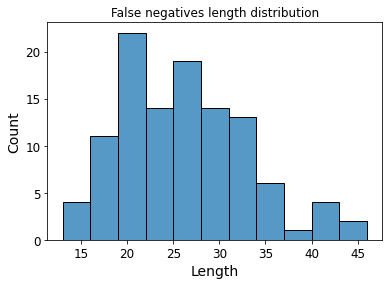

In [ ]:
# False negatives length distribution
fneg_lengths = []
for sp in fneg_df["SP cleavage-site annotation"]:
  count = 0
  for char in sp:
    if char == 'S':
      count += 1
  fneg_lengths.append(count)

# plot
ax = sns.histplot(fneg_lengths, binwidth=3)

ax.set(xlabel='Length', ylabel='Count', title='False negatives length distribution')
img = ax.get_figure()
plt.show()
img.savefig('FalseNeg_length_histplot.png')

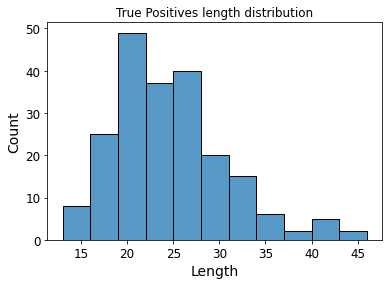

In [ ]:
# True Positives length distribution

bm_sp = bm_df[bm_df['Real Class'] == 1]
bm_lengths = []
for sp in bm_sp["SP cleavage-site annotation"]:
  count = 0
  for char in sp:
    if char == 'S':
      count += 1
  bm_lengths.append(count)

ax = sns.histplot(bm_lengths, binwidth=3)

ax.set(xlabel='Length', ylabel='Count', title='True Positives length distribution')
img = ax.get_figure()
img.savefig('TruePos_length_histplot.png')

#### False negatives have a different composition: compositional analysis

In [ ]:
# Training SP composition

df = pd.read_table('training_set.tsv')
df_sp = df[df.Class == 'SP']
num_seq = df_sp.shape[0]

sp_freq = {}
for n_term in df_sp["Sequence (first 50 N-terminal residues)"]:
  for aa in n_term:
    if aa in sp_freq:
      sp_freq[aa] += 100/(num_seq*50)
    else: 
      sp_freq[aa] = 0
      
print(sp_freq)

# Convert dict to df
sp_freq_df = pd.DataFrame.from_dict(sp_freq, orient='index')
sp_freq_df.columns = ['freq']
sp_freq_df.reset_index(level=0, inplace=True)

# Sort by polarity
sp_freq_df['index'] = pd.Categorical(sp_freq_df['index'], ["G","A","V","P","L","I","M","F","W","Y","S","T","C","N","Q","H","D","E","K","R"])
sp_freq_df.sort_values("index",inplace=True)
sp_freq_df.rename(columns={'index':'id'}, inplace=True)
sp_freq_df.tail()

{'M': 3.7054263565891534, 'R': 3.8294573643410916, 'F': 4.372093023255821, 'L': 13.930232558139558, 'A': 9.558139534883736, 'T': 5.465116279069776, 'S': 7.612403100775206, 'Q': 3.240310077519385, 'E': 4.000000000000006, 'P': 5.333333333333342, 'V': 7.56589147286823, 'K': 4.007751937984502, 'D': 3.3875968992248118, 'C': 3.8682170542635723, 'G': 7.255813953488384, 'I': 4.178294573643417, 'N': 3.0232558139534933, 'Y': 2.263565891472872, 'W': 1.5658914728682196, 'H': 1.6821705426356617}


,id,freq
19,H,1.682171
12,D,3.387597
8,E,4.000000
11,K,4.007752
1,R,3.829457


In [ ]:
sp_freq_df['freq'].sum()

99.84496124031024

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


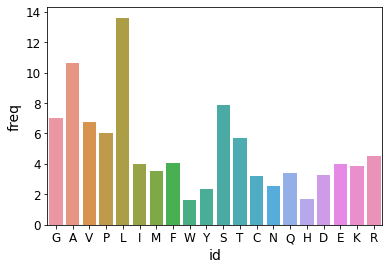

In [ ]:
# Benchmark SP composition

bm_sp = bm_df[bm_df['Real Class'] == 1]

sp_freq = {}
for n_term in bm_sp["Sequence (first 50 N-terminal residues)"]:
  for aa in n_term:
    if aa in sp_freq:
      sp_freq[aa] += 100/(209*50)
    else: 
      sp_freq[aa] = 0

# Convert dict to df
bm_sp_freq_df = pd.DataFrame.from_dict(sp_freq, orient='index')
bm_sp_freq_df.columns = ['freq']
bm_sp_freq_df.reset_index(level=0, inplace=True)

# Sort by polarity
bm_sp_freq_df['index'] = pd.Categorical(bm_sp_freq_df['index'], ["G","A","V","P","L","I","M","F","W","Y","S","T","C","N","Q","H","D","E","K","R"])
bm_sp_freq_df.sort_values("index",inplace=True)
bm_sp_freq_df.rename(columns={'index':'id'}, inplace=True)
bm_sp_freq_df.tail()

# Plot
sns.barplot(bm_sp_freq_df['id'], y=bm_sp_freq_df['freq'])

In [ ]:
bm_sp_freq_df['freq'].sum()

99.80861244019184

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


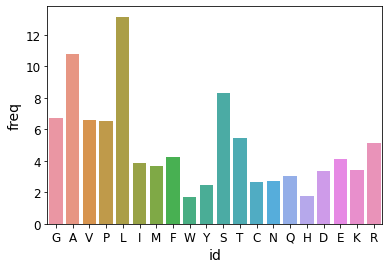

In [ ]:
# False negatives SP composition

fneg_sp_freq = {}
for n_term in fneg_df["Sequence (first 50 N-terminal residues)"]:
  for aa in n_term:
    if aa in fneg_sp_freq:
      fneg_sp_freq[aa] += 100/(110*50)
    else: 
      fneg_sp_freq[aa] = 0
      
# Convert dict to df
fneg_sp_freq_df = pd.DataFrame.from_dict(fneg_sp_freq, orient='index')
fneg_sp_freq_df.columns = ['freq']
fneg_sp_freq_df.reset_index(level=0, inplace=True)

# Sort by polarity
fneg_sp_freq_df['index'] = pd.Categorical(fneg_sp_freq_df['index'], ["G","A","V","P","L","I","M","F","W","Y","S","T","C","N","Q","H","D","E","K","R"])
fneg_sp_freq_df.sort_values("index",inplace=True)
fneg_sp_freq_df.rename(columns={'index':'id'}, inplace=True)
fneg_sp_freq_df.tail()

# Plot
sns.barplot(fneg_sp_freq_df['id'], y=fneg_sp_freq_df['freq'])

In [ ]:
fneg_sp_freq_df['freq'].sum()

99.63636363636353

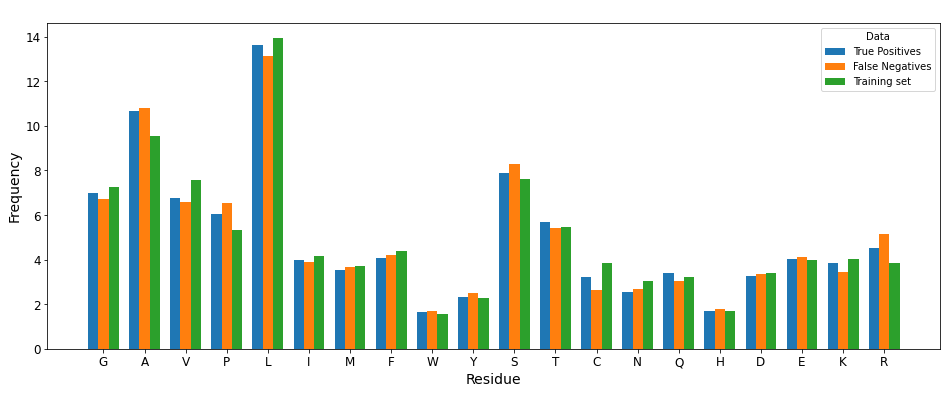

In [ ]:
# Compare compositions - MATPLOTLIB

plt.figure(figsize=(16, 6))
width = 0.25
sp_freq_df.shape[0]
plt.bar(np.arange(sp_freq_df.shape[0])-width, bm_sp_freq_df["freq"], width, label="True Positives")
plt.bar(np.arange(sp_freq_df.shape[0]), fneg_sp_freq_df["freq"], width, label="False Negatives")
plt.bar(np.arange(sp_freq_df.shape[0])-width+0.5, sp_freq_df["freq"], width, label="Training set")


plt.xticks(np.arange(len(bg_aa)), bg_aa["id"])

plt.title(" ")
plt.legend(title="Data")
plt.xlabel('Residue')
plt.ylabel('Frequency')
plt.savefig('FalseNeg_comparative_analysis.png')
plt.show()

##### Seaborn

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


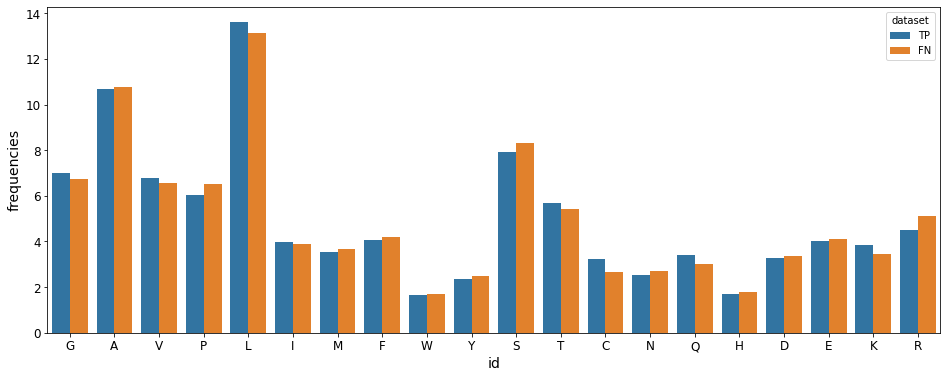

In [ ]:
# Compare compositions - SEABORN

plt.figure(figsize=(16,6))
merged = pd.merge(fneg_sp_freq_df, sp_freq_df, on='id')
merged.rename(columns={'freq_x':'FN', 'freq_y':'TP'}, inplace=True)
merged = merged[['id', 'TP', 'FN']]
merged = merged.melt(id_vars=['id'], var_name='dataset', value_name='frequencies')
merged.tail()

sns.barplot(merged['id'], y=merged['frequencies'], hue=merged['dataset'])
plt.show()

#### Bias toward a source organism: taxonomy analysis

Since the composition of the signal may differ according to source organism, the model may become specific for a given kingdom.
To check for that: analyze the False Negatives abundances on the different 
kingdoms.

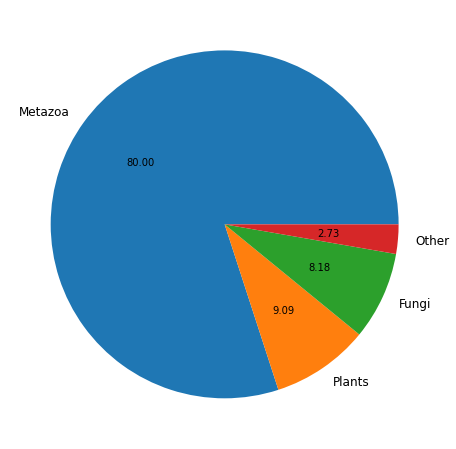

In [ ]:
# Kingdom
kingdoms = fneg_df['Kingdom'].value_counts()
plot = kingdoms.plot.pie(figsize=(8,8), autopct='%.2f')
plt.ylabel('')
plt.savefig('kingdom_bias.png')

### von Heijne

Check for the algorithms assumptions:
- Von Heijne method -> SP is around cleavage site; Collect FN and compute a logo(-13;+2) and compare with TP logo: in principle, the TP logo should be more similar to original set logo, while in FN logo we should see something missing.
This allows to highlight a possibly different composition of the the False Negatives set, thus informing us that composition can't be assumed.

#### Logo comparison

False negatives:

![image.png](https://weblogo.berkeley.edu/cache/fileIeFzPF.png)

True positives:

![image.png](https://weblogo.berkeley.edu/cache/filemeAOTp.png)

Training set:

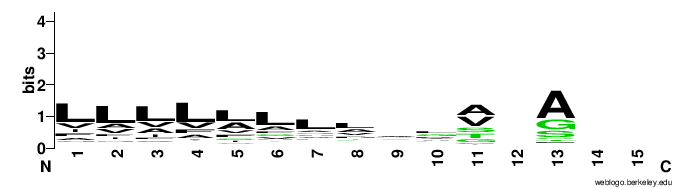

Training set is way more similar to the true positives in respect to the false negatives. This justify the classification error made by the model, since it is caused by a different composition.